In [1]:
import random
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from pysat.formula import CNF
from pysat.solvers import Solver
from typing import Literal, Iterable

sns.set()

In [2]:
class SplittableCNF:
    def __init__(self, clauses: list[list[int]] | None = None) -> None:
        self.unit_clauses = []
        self.multi_clauses = []
        if clauses:
            for c in clauses:
                self.append(c)

    @property
    def clauses(self):
        return self.unit_clauses + self.multi_clauses

    def append(self, clause: list[int]):
        assert len(clause) > 0

        if len(clause) == 1:
            self.unit_clauses.append(clause)
        else:
            self.multi_clauses.append(clause)

    def copy(self) -> "SplittableCNF":
        f = SplittableCNF()
        f.unit_clauses = copy.deepcopy(self.unit_clauses)
        f.multi_clauses = copy.deepcopy(self.multi_clauses)
        return f

    def can_split(self) -> bool:
        return len(self.multi_clauses) > 0

    def random_split(self) -> None:
        if not self.can_split():
            raise RuntimeError("No clauses left to split")

        i = random.randrange(len(self.multi_clauses))
        clause = self.multi_clauses.pop(i)

        partition_point = random.randrange(1, len(clause))
        self.append(clause[:partition_point])
        self.append(clause[partition_point:])

    @staticmethod
    def from_file(file: str) -> "SplittableCNF":
        src = CNF(from_file=file)
        return SplittableCNF(src.clauses)

    def __repr__(self):
        return f"SplittableCNF({self.clauses})"


In [3]:
# f = CNF(from_file="../instances/sat/2022/0b495cc867003b7ac112b7c47256228b-h31_large.cnf.xz")
def random_k_sat(n_vars=100, n_clauses=420, k=3) -> SplittableCNF:
    f = SplittableCNF()
    for _ in range(n_clauses):
        variables = np.random.choice(1 + np.arange(n_vars), size=k)
        polarities = np.random.choice([1, -1], size=k)
        literals = variables * polarities
        f.append(literals.tolist())
    return f


def solve_cnf(f: SplittableCNF, solver_name: str = "m22"):
    s = Solver(solver_name, bootstrap_with=f.clauses, use_timer=True)
    sat = s.solve()
    stats = s.accum_stats() or {}
    stats["sat"] = sat
    stats["time"] = s.time()
    return stats


def compute_split_stats(
    fs: list[SplittableCNF], solver_name: str = "m22", runs: int = 1
) -> pd.DataFrame:
    def inner_solve(f: SplittableCNF, instance: int, splits: int, run: int) -> dict:
        return solve_cnf(f, solver_name) | {
            "instance": instance,
            "splits": splits,
            "run": run,
        }

    results = []
    for instance, f0 in enumerate(fs):
        for run in range(runs):
            f = f0.copy()
            splits = 0
            results.append(inner_solve(f, instance, splits, run))
            while f.can_split():
                f.random_split()
                splits += 1
                results.append(inner_solve(f, instance, splits, run))

    df = pd.DataFrame(results)
    return df


In [4]:
fs = [random_k_sat() for _ in range(10)]
all_stats = compute_split_stats(fs, runs=5)

In [5]:
all_stats

,restarts,conflicts,decisions,propagations,sat,time,instance,splits,run
0,1,64,107,1528,True,0.000257,0,0,0
1,3,257,301,5874,False,0.000904,0,1,0
2,1,87,101,1941,False,0.000272,0,2,0
3,1,31,36,719,False,0.000104,0,3,0
4,1,25,29,583,False,0.000095,0,4,0
...,...,...,...,...,...,...,...,...,...
42045,0,0,0,14,False,0.000006,9,836,4
42046,0,0,0,14,False,0.000006,9,837,4
42047,0,0,0,14,False,0.000008,9,838,4
42048,0,0,0,14,False,0.000006,9,839,4


<Axes: xlabel='splits', ylabel='decisions'>

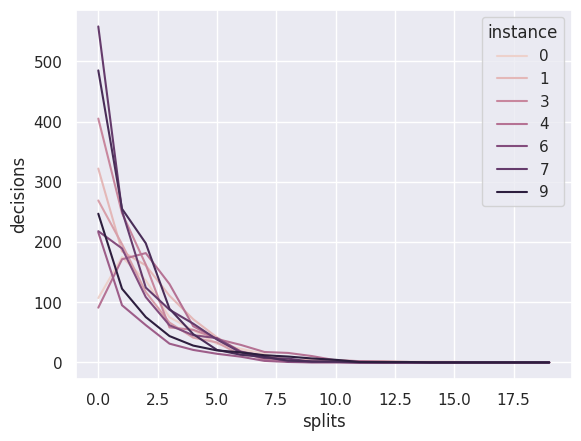

In [6]:
sns.lineplot(x="splits", y="decisions", hue="instance", errorbar=None, data=all_stats[(all_stats["splits"] < 20)])

In [7]:
s = all_stats.set_index(["instance", "splits", "run"])

In [8]:
def get_lagged(stats: pd.DataFrame, col: str, lag: int = 1, mean: bool = False):
    original = []
    lagged = []
    if mean:
        stats = stats.groupby(["instance", "splits"]).mean()
    else:
        stats = stats.set_index(["instance", "splits", "run"])
    for _, g in stats.groupby(["instance", "run"]):
        g_col = g[col]
        original.append(g_col)
        lagged.append(g_col.shift(lag))
    return pd.DataFrame(
        {"current": pd.concat(original), "prev": pd.concat(lagged)}
    ).dropna()


def get_col_or_index(df: pd.DataFrame, name: str):
    if name in df:
        return df[name]
    return df.index.get_level_values(name)


def rolling_corr(
    df: pd.DataFrame,
    x: str,
    y: str,
    window: int,
    on: str,
    method: Literal["pearson", "kendall", "spearman"] = "pearson",
):
    on_col = get_col_or_index(df, on)

    starts = range(on_col.min(), on_col.max() - window + 2)
    corrs = []
    for start in starts:
        end = start + window
        windowed = df[(start <= on_col) & (on_col < end)][[x, y]]
        corrs.append(windowed.corr(method).iloc[0, 1])
    corrs = pd.Series(corrs, index=starts, name="corr")
    corrs.index.name = on + "_start"
    return corrs


def autocorr(
    stats: pd.DataFrame,
    col: str,
    method: Literal["pearson", "kendall", "spearman"] = "pearson",
    lags: Iterable[int] = (1,),
    mean: bool = False,
    windows: Iterable[int | None] = (None, ),
):
    results = []
    for lag in lags:
        lagged = get_lagged(stats, col, lag, mean)
        splits = get_col_or_index(lagged, "splits")
        max_window = splits.max() - splits.min() + 1
        for window in windows:
            if window is None:
                window = max_window
            corrs = rolling_corr(
                lagged, "current", "prev", window=window, on="splits", method=method
            )
            corrs_df = corrs.reset_index()
            corrs_df["splits_end"] = corrs_df["splits_start"] + window
            corrs_df["window"] = window
            corrs_df["lag"] = lag
            results.append(corrs_df)
    return pd.concat(results, ignore_index=True)


In [9]:
corr = autocorr(all_stats, "time", lags=[1, 5, 25], windows=[20])

In [10]:
corr

,splits_start,corr,splits_end,window,lag
0,1,0.833324,21,20,1
1,2,0.871481,22,20,1
2,3,0.855807,23,20,1
3,4,0.830668,24,20,1
4,5,0.819445,25,20,1
...,...,...,...,...,...
2430,817,0.067506,837,20,25
2431,818,0.060725,838,20,25
2432,819,0.060522,839,20,25
2433,820,0.050367,840,20,25


<Axes: xlabel='splits_start', ylabel='corr'>

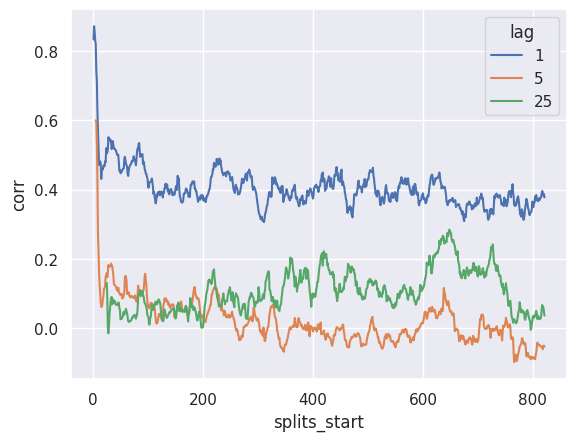

In [11]:
sns.lineplot(x="splits_start", y="corr", hue=corr["lag"].astype("str"), data=corr)